In [ ]:
# =========================================================
# PhysicsPrior notebook bootstrap via module import
# =========================================================
import importlib.util
import os
import pathlib
import sys
import time

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from contextlib import nullcontext
from sklearn.metrics import average_precision_score, precision_recall_curve
from tqdm.auto import tqdm

repo_root = pathlib.Path.cwd()
module_path = repo_root / "mNDWS_models copy.py"
print(f"Loading shared models module from: {module_path}")
spec = importlib.util.spec_from_file_location("mndws_models_copy", module_path)
models = importlib.util.module_from_spec(spec)
spec.loader.exec_module(models)
sys.modules["mndws_models_copy"] = models

set_seed = models.set_seed
set_seed(1337)

device = models.device
use_cuda = models.use_cuda
use_mps = models.use_mps
print("Device:", device)


Device: mps


In [ ]:
# --- Reuse pipeline + loader configuration from shared module ---
BATCH_SIZE = 16
train_ds, val_ds, test_ds, train_loader, val_loader, test_loader, meanC, stdC = models.pipeline_hookup(
    BATCH_SIZE=BATCH_SIZE
)
CHANNELS_FOR_MODEL = list(train_ds.channels)
print(f"Channels configured ({len(CHANNELS_FOR_MODEL)}): {CHANNELS_FOR_MODEL}")


Reusing NPZ tiles from pipeline at: /Users/queclay/wildfire_npz_tiles_mndws_v1
Channels configured (21): ['prev_fire', 'u', 'v', 'temp', 'rh', 'ndvi', 'slope', 'aspect', 'barrier', 'erc', 'pdsi', 'pr', 'bi', 'chili', 'fuel1', 'fuel2', 'fuel3', 'impervious', 'water', 'wind_75', 'gust_med']
Channels configured (21): ['prev_fire', 'u', 'v', 'temp', 'rh', 'ndvi', 'slope', 'aspect', 'barrier', 'erc', 'pdsi', 'pr', 'bi', 'chili', 'fuel1', 'fuel2', 'fuel3', 'impervious', 'water', 'wind_75', 'gust_med']


In [ ]:
# =========================================================
# PhysicsPrior UNet bundle + optimizer/criterion setup
# =========================================================
bundle = models.build_physics_unet_bundle(CHANNELS_FOR_MODEL, meanC, stdC, base_width=80, ema_decay=0.999)
physics_model = bundle["model"]
feature_builder = bundle["feature_builder"]
ema_tracker = bundle["ema"]
polyak_tracker = bundle["polyak"]

pos_weight = models.pos_weight_from_loader(train_loader)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = torch.optim.AdamW(physics_model.parameters(), lr=2e-4, weight_decay=1e-4)
amp_enabled = use_cuda
scaler = torch.cuda.amp.GradScaler(enabled=amp_enabled)
autocast_ctx = torch.cuda.amp.autocast if amp_enabled else nullcontext

print(f"pos_weight = {float(pos_weight):.3f}")
print(f"Model parameters: {sum(p.numel() for p in physics_model.parameters() if p.requires_grad)/1e6:.2f} M")


in_ch = 21 pos_weight = 32.9764289855957


In [ ]:
# =========================================================
# Train / Eval loops for PhysicsPrior UNet
# =========================================================
EPOCHS_PHYSICS = 30
amp_stream = autocast_ctx

train_loss_hist, val_ap_hist, val_f1_hist, val_thr_hist = [], [], [], []
best_val_ap = -1.0
best_state = None

peak_gpu_gb = None
epoch_times = []
epoch_tiles = []
compute_metrics = {
    "param_count": int(sum(p.numel() for p in physics_model.parameters() if p.requires_grad)),
}

if use_cuda:
    torch.cuda.reset_peak_memory_stats(device)


def _forward_batch(model_obj, batch):
    X_raw = batch["X_raw"].to(device, non_blocking=True)
    y = batch["y"].to(device, non_blocking=True)
    feats = feature_builder(X_raw)
    return feats, y


def train_physics_epoch():
    physics_model.train()
    losses = []
    tiles_seen = 0
    for batch in tqdm(train_loader, desc="train Physics", leave=False):
        feats, y = _forward_batch(physics_model, batch)
        optimizer.zero_grad(set_to_none=True)
        with amp_stream():
            logits = physics_model(feats)
            loss = criterion(logits, y)
        if amp_enabled:
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            loss.backward()
            optimizer.step()
        ema_tracker.update(physics_model)
        polyak_tracker.update(physics_model)
        losses.append(loss.item())
        tiles_seen += feats.size(0)
    return float(np.mean(losses)), tiles_seen


@torch.no_grad()
def eval_physics(model_obj, loader, desc="eval Physics"):
    model_obj.eval()
    all_p, all_t = [], []
    for batch in tqdm(loader, desc=desc, leave=False):
        feats, y = _forward_batch(model_obj, batch)
        logits = model_obj(feats)
        p = torch.sigmoid(logits).flatten().cpu().numpy()
        t = y.flatten().cpu().numpy()
        all_p.append(p)
        all_t.append(t)
    p = np.concatenate(all_p)
    t = np.concatenate(all_t)
    if t.sum() == 0:
        return 0.0, 0.0, 0.5
    ap = average_precision_score(t, p)
    prec, rec, thr = precision_recall_curve(t, p)
    f1 = (2 * prec * rec) / (prec + rec + 1e-8)
    best_idx = f1.argmax()
    best_thr = thr[best_idx] if best_idx < len(thr) else 0.5
    return float(ap), float(f1.max()), float(best_thr)


best_thr_val = 0.5

for epoch in range(EPOCHS_PHYSICS):
    if use_cuda:
        torch.cuda.synchronize(device)
    elif use_mps:
        torch.mps.synchronize()
    epoch_start = time.perf_counter()
    tr_loss, tiles_seen = train_physics_epoch()
    if use_cuda:
        torch.cuda.synchronize(device)
    elif use_mps:
        torch.mps.synchronize()
    epoch_duration = time.perf_counter() - epoch_start
    epoch_times.append(epoch_duration)
    epoch_tiles.append(tiles_seen)
    ap, f1, thr = eval_physics(physics_model, val_loader)
    train_loss_hist.append(tr_loss)
    val_ap_hist.append(ap)
    val_f1_hist.append(f1)
    val_thr_hist.append(thr)
    print(f"[Physics] Epoch {epoch:02d} | loss {tr_loss:.4f} | VAL AP {ap:.4f} | VAL F1* {f1:.4f} | thr≈{thr:.3f}")
    if ap > best_val_ap:
        best_val_ap = ap
        best_state = {k: v.cpu().clone() for k, v in physics_model.state_dict().items()}

if best_state is not None:
    physics_model.load_state_dict(best_state)

best_thr_val = val_thr_hist[-1] if val_thr_hist else 0.5

if epoch_times:
    avg_epoch = float(np.mean(epoch_times))
    std_epoch = float(np.std(epoch_times))
    total_time = float(np.sum(epoch_times))
    total_tiles = int(np.sum(epoch_tiles)) if epoch_tiles else 0
    throughput = float(total_tiles / total_time) if total_time > 0 else None
else:
    avg_epoch = std_epoch = throughput = None

if use_cuda:
    torch.cuda.synchronize(device)
    peak_gpu_gb = float(torch.cuda.max_memory_allocated(device) / (1024 ** 3))
elif use_mps:
    torch.mps.synchronize()

@torch.no_grad()
def measure_latency(ds, model_obj, repeats=50):
    if len(ds) == 0:
        return None
    model_obj.eval()
    sample = ds[0]["X_raw"].unsqueeze(0).to(device)
    feats = feature_builder(sample)
    if use_cuda:
        torch.cuda.synchronize(device)
    elif use_mps:
        torch.mps.synchronize()
    start = time.perf_counter()
    for _ in range(repeats):
        torch.sigmoid(model_obj(feats))
    if use_cuda:
        torch.cuda.synchronize(device)
    elif use_mps:
        torch.mps.synchronize()
    return (time.perf_counter() - start) / repeats

latency_s = measure_latency(test_ds, physics_model, repeats=100)

compute_metrics.update({
    "avg_epoch": avg_epoch,
    "std_epoch": std_epoch,
    "throughput_tiles_per_s": throughput,
    "peak_gpu_gb": peak_gpu_gb,
    "latency_s": latency_s,
})


No cached PixelLogReg artifact found; training from scratch.


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 00 | loss 1.3243 | VAL AP 0.0500 | VAL F1* 0.1029 | thr≈0.644


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 01 | loss 1.2545 | VAL AP 0.0651 | VAL F1* 0.1299 | thr≈0.669


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 02 | loss 1.2413 | VAL AP 0.0780 | VAL F1* 0.1533 | thr≈0.675


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 03 | loss 1.2148 | VAL AP 0.0883 | VAL F1* 0.1725 | thr≈0.686


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 04 | loss 1.1952 | VAL AP 0.0966 | VAL F1* 0.1837 | thr≈0.696


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 05 | loss 1.1528 | VAL AP 0.1102 | VAL F1* 0.2030 | thr≈0.698


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 06 | loss 1.1357 | VAL AP 0.1199 | VAL F1* 0.2160 | thr≈0.698


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 07 | loss 1.1683 | VAL AP 0.1312 | VAL F1* 0.2333 | thr≈0.696


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 08 | loss 1.1030 | VAL AP 0.1421 | VAL F1* 0.2496 | thr≈0.703


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 09 | loss 1.0942 | VAL AP 0.1550 | VAL F1* 0.2647 | thr≈0.707


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 10 | loss 1.1040 | VAL AP 0.1687 | VAL F1* 0.2822 | thr≈0.711


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 11 | loss 1.1200 | VAL AP 0.1792 | VAL F1* 0.2928 | thr≈0.712


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 12 | loss 1.0805 | VAL AP 0.1850 | VAL F1* 0.3014 | thr≈0.724


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 13 | loss 1.1053 | VAL AP 0.1957 | VAL F1* 0.3166 | thr≈0.717


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 14 | loss 1.0553 | VAL AP 0.2072 | VAL F1* 0.3316 | thr≈0.716


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 15 | loss 1.0535 | VAL AP 0.2122 | VAL F1* 0.3372 | thr≈0.727


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 16 | loss 1.0298 | VAL AP 0.2165 | VAL F1* 0.3427 | thr≈0.720


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 17 | loss 1.0576 | VAL AP 0.2176 | VAL F1* 0.3460 | thr≈0.728


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 18 | loss 1.0749 | VAL AP 0.2234 | VAL F1* 0.3538 | thr≈0.731


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 19 | loss 1.0520 | VAL AP 0.2298 | VAL F1* 0.3638 | thr≈0.721


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 20 | loss 1.0556 | VAL AP 0.2317 | VAL F1* 0.3674 | thr≈0.728


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 21 | loss 1.0269 | VAL AP 0.2315 | VAL F1* 0.3706 | thr≈0.734


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 22 | loss 1.0433 | VAL AP 0.2344 | VAL F1* 0.3736 | thr≈0.737


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 23 | loss 1.0383 | VAL AP 0.2371 | VAL F1* 0.3787 | thr≈0.740


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 24 | loss 1.0134 | VAL AP 0.2415 | VAL F1* 0.3876 | thr≈0.728


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 25 | loss 0.9891 | VAL AP 0.2454 | VAL F1* 0.3921 | thr≈0.738


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 26 | loss 1.0157 | VAL AP 0.2471 | VAL F1* 0.3946 | thr≈0.741


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 27 | loss 1.0201 | VAL AP 0.2446 | VAL F1* 0.3938 | thr≈0.751


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 28 | loss 0.9873 | VAL AP 0.2477 | VAL F1* 0.3995 | thr≈0.744


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 29 | loss 1.0186 | VAL AP 0.2513 | VAL F1* 0.4083 | thr≈0.751


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 30 | loss 0.9818 | VAL AP 0.2504 | VAL F1* 0.4111 | thr≈0.756


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 31 | loss 0.9660 | VAL AP 0.2506 | VAL F1* 0.4127 | thr≈0.766


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 32 | loss 0.9760 | VAL AP 0.2513 | VAL F1* 0.4179 | thr≈0.760


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 33 | loss 0.9591 | VAL AP 0.2514 | VAL F1* 0.4192 | thr≈0.756


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 34 | loss 0.9980 | VAL AP 0.2502 | VAL F1* 0.4170 | thr≈0.771


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 35 | loss 1.0058 | VAL AP 0.2483 | VAL F1* 0.4130 | thr≈0.780


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 36 | loss 0.9460 | VAL AP 0.2514 | VAL F1* 0.4189 | thr≈0.780


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 37 | loss 0.9788 | VAL AP 0.2524 | VAL F1* 0.4205 | thr≈0.786


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 38 | loss 0.9985 | VAL AP 0.2518 | VAL F1* 0.4187 | thr≈0.792


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 39 | loss 0.9767 | VAL AP 0.2511 | VAL F1* 0.4206 | thr≈0.792


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 40 | loss 0.9795 | VAL AP 0.2511 | VAL F1* 0.4210 | thr≈0.802


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 41 | loss 0.9696 | VAL AP 0.2511 | VAL F1* 0.4220 | thr≈0.800


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 42 | loss 0.9190 | VAL AP 0.2534 | VAL F1* 0.4251 | thr≈0.803


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 43 | loss 0.9891 | VAL AP 0.2535 | VAL F1* 0.4274 | thr≈0.773


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 44 | loss 0.9813 | VAL AP 0.2537 | VAL F1* 0.4272 | thr≈0.778


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 45 | loss 0.9531 | VAL AP 0.2544 | VAL F1* 0.4295 | thr≈0.781


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 46 | loss 0.9832 | VAL AP 0.2510 | VAL F1* 0.4251 | thr≈0.819


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 47 | loss 0.9932 | VAL AP 0.2516 | VAL F1* 0.4260 | thr≈0.806


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 48 | loss 0.9778 | VAL AP 0.2535 | VAL F1* 0.4298 | thr≈0.801


train LR:   0%|          | 0/75 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] Epoch 49 | loss 0.9954 | VAL AP 0.2527 | VAL F1* 0.4301 | thr≈0.802


eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

test LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] TEST @thr=0.781 | AP=0.2340 | P=0.381 R=0.450 F1=0.413


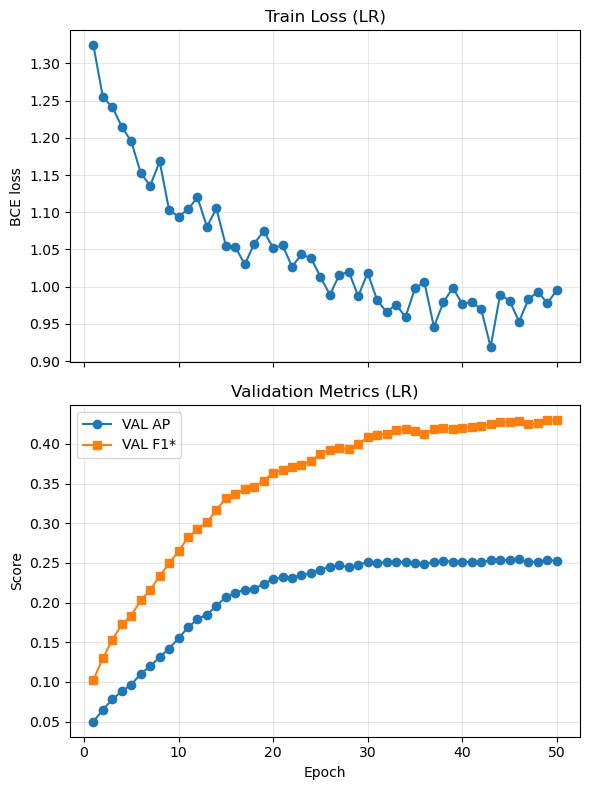

In [ ]:
if not train_loss_hist:
    print("Training history empty — rerun the training cell to populate curves.")
else:
    epochs = np.arange(1, len(train_loss_hist) + 1)
    fig, axes = plt.subplots(2, 1, figsize=(6, 8), sharex=True)
    axes[0].plot(epochs, train_loss_hist, marker="o")
    axes[0].set_title("Train Loss (Physics)")
    axes[0].set_ylabel("BCE loss")
    axes[0].grid(True, alpha=0.3)
    metric_epochs = np.arange(1, len(val_ap_hist) + 1)
    axes[1].plot(metric_epochs, val_ap_hist, marker="o", label="VAL AP")
    axes[1].plot(metric_epochs, val_f1_hist, marker="s", label="VAL F1*")
    axes[1].set_title("Validation Metrics (Physics)")
    axes[1].set_xlabel("Epoch")
    axes[1].set_ylabel("Score")
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    plt.tight_layout()


In [ ]:
def _format_metric(val, unit=None, precision=3):
    if val is None:
        return "—"
    if isinstance(val, (int, np.integer)) and unit is None:
        return f"{int(val)}"
    if isinstance(val, (float, np.floating)):
        if np.isnan(val):
            return "—"
        if unit == "ms":
            return f"{val * 1e3:.3f} {unit}"
        if unit == "GB":
            return f"{val:.3f} {unit}"
        return f"{val:.3f}{'' if unit is None else ' ' + unit}"
    return str(val)

compute_metrics_display = {
    "Learnable parameters": _format_metric(compute_metrics.get("param_count")),
    "Avg. epoch wall time": _format_metric(compute_metrics.get("avg_epoch"), unit="s"),
    "Epoch time stdev": _format_metric(compute_metrics.get("std_epoch"), unit="s"),
    "Training throughput": _format_metric(compute_metrics.get("throughput_tiles_per_s"), unit="tiles/s"),
    "Peak GPU memory": _format_metric(compute_metrics.get("peak_gpu_gb"), unit="GB"),
    "Inference latency (1 tile)": _format_metric(compute_metrics.get("latency_s"), unit="ms"),
}

print("\n[Physics] Computation metrics summary:")
for k, v in compute_metrics_display.items():
    print(f"  {k:28s} {v}")



[LR] Computation metrics summary:
  Learnable parameters         22
  Avg. epoch wall time         0.694 s
  Epoch time stdev             0.079 s
  Training throughput          1730.213 tiles/s
  Peak GPU memory              —
  Inference latency (1 tile)   0.103 ms


In [27]:
sample = train_ds[0]          # grab the first tile from the training split
img = sample["X_raw"]         # shape (channels, height, width)
print("Tensor shape:", img.shape)
print("Height x Width:", img.shape[1], "x", img.shape[2])

Tensor shape: torch.Size([21, 64, 64])
Height x Width: 64 x 64



[LR] Coefficients (sorted by |weight|):
  prev_fire        +2.4942
  gust_med         +0.3600
  erc              +0.2623
  wind_75          -0.2583
  pdsi             -0.2462
  barrier          -0.2294
  temp             +0.1967
  bi               +0.1941
  fuel2            +0.1090
  rh               -0.1058
  water            -0.1050
  slope            +0.0761
  ... (+9 more)
[LR] Bias: -0.6700


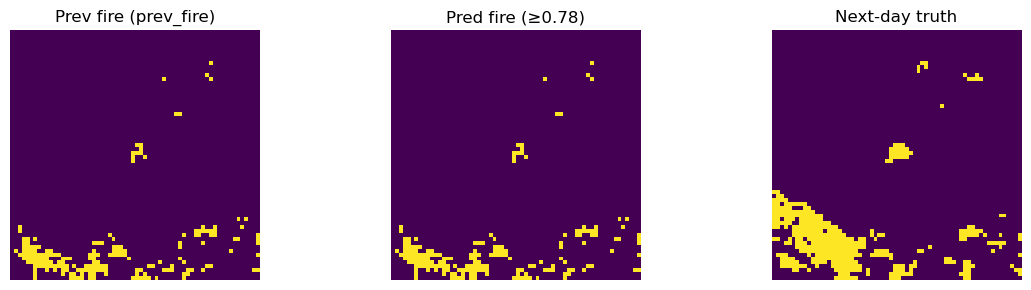

In [ ]:
# =========================================================
# Quick qualitative visualization for PhysicsPrior UNet
# =========================================================
@torch.no_grad()
def show_one_physics(ds, model_obj=None, i=0, thr=None):
    if model_obj is None:
        model_obj = physics_model
    if thr is None:
        thr = best_thr_val
    names = ds.channels
    prev_idx = names.index("prev_fire") if "prev_fire" in names else 0
    batch = ds[i]
    X_raw0 = batch["X_raw"].unsqueeze(0).to(device)
    y = batch["y"][0].numpy()
    feats = feature_builder(X_raw0)
    prob = torch.sigmoid(model_obj(feats))[0, 0].cpu().numpy()
    pred_fire = (prob >= float(thr)).astype(np.float32)
    prev_img = batch["X_raw"][prev_idx].numpy()

    fig, axs = plt.subplots(1, 3, figsize=(12, 3))
    axs[0].imshow(prev_img, vmin=0, vmax=1)
    axs[0].set_title(f"Prev fire ({names[prev_idx]})")
    axs[1].imshow(pred_fire, vmin=0, vmax=1)
    axs[1].set_title(f"Pred fire (≥{thr:.2f})")
    axs[2].imshow(y, vmin=0, vmax=1)
    axs[2].set_title("Next-day truth")
    for a in axs:
        a.axis('off')
    plt.tight_layout()

# Example
show_one_physics(test_ds, i=0)


In [ ]:
# =========================================================
# Save PhysicsPrior artifacts (raw, EMA, Polyak)
# =========================================================
ART_DIR = os.path.join(os.environ.get("ARTIFACTS_DIR", os.path.expanduser("~/wildfire_artifacts")), "physics_unet")
os.makedirs(ART_DIR, exist_ok=True)
ART_PATH = os.path.join(ART_DIR, "physics_unet.pt")

artifact = {
    "model": {
        "type": "PhysicsUNet",
        "in_ch": feature_builder.output_channels,
        "base": 80,
    },
    "channels": CHANNELS_FOR_MODEL,
    "state_dict": {k: v.cpu() for k, v in physics_model.state_dict().items()},
    "ema_state_dict": {k: v.cpu() for k, v in ema_tracker.shadow.items()},
    "polyak_state_dict": {k: v.cpu() for k, v in polyak_tracker.shadow.items()},
    "mean": meanC.cpu(),
    "std": stdC.cpu(),
    "best_thr": float(best_thr_val),
    "train_loss_hist": list(train_loss_hist),
    "val_ap_hist": list(val_ap_hist),
    "val_f1_hist": list(val_f1_hist),
    "val_thr_hist": list(val_thr_hist),
    "compute_metrics": dict(compute_metrics),
}

torch.save(artifact, ART_PATH)
print(f"Saved model → {ART_PATH}")


Saved model → /Users/queclay/wildfire_artifacts/lr/pixel_logreg.pt


In [ ]:
# =========================================================
# Final validation/test metrics for raw, EMA, Polyak variants
# =========================================================
variants = {"Raw": physics_model}

def _clone_model():
    clone = models.PhysicsUNet(
        in_ch=feature_builder.output_channels,
        out_ch=1,
        base=80,
    ).to(device)
    return clone

ema_model = _clone_model()
ema_tracker.copy_to(ema_model)
variants["EMA"] = ema_model

polyak_model = _clone_model()
polyak_tracker.copy_to(polyak_model)
variants["Polyak"] = polyak_model

final_metrics = {}
for name, model_obj in variants.items():
    ap_val, f1_val, thr_val = eval_physics(model_obj, val_loader, desc=f"VAL {name}")
    ap_test, f1_test, thr_test = eval_physics(model_obj, test_loader, desc=f"TEST {name}")
    final_metrics[name] = {
        "val_ap": ap_val,
        "val_f1": f1_val,
        "val_thr": thr_val,
        "test_ap": ap_test,
        "test_f1": f1_test,
        "test_thr": thr_test,
    }

print("Final metrics (val/test):")
for name, stats in final_metrics.items():
    print(
        f"  {name:6s} | VAL AP {stats['val_ap']:.4f} F1 {stats['val_f1']:.4f} thr≈{stats['val_thr']:.3f}"
        f" | TEST AP {stats['test_ap']:.4f} F1 {stats['test_f1']:.4f}"
    )


(0.23401248040019057, 0.41297802259147404)

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

[LR] VAL: AP=0.2544 F1*=0.4295 thr≈0.781
VAL @thr: {'tp': 16762, 'fp': 23993, 'tn': 1167502, 'fn': 20543, 'precision': 0.4112869586552788, 'recall': 0.44932314703110865, 'f1': 0.4294645094857008}
TEST @thr: {'tp': 17489, 'fp': 28378, 'tn': 1161592, 'fn': 21341, 'precision': 0.3812981010311594, 'recall': 0.45039917589481065, 'f1': 0.41297802259147404}
VAL @thr: {'tp': 16762, 'fp': 23993, 'tn': 1167502, 'fn': 20543, 'precision': 0.4112869586552788, 'recall': 0.44932314703110865, 'f1': 0.4294645094857008}
TEST @thr: {'tp': 17489, 'fp': 28378, 'tn': 1161592, 'fn': 21341, 'precision': 0.3812981010311594, 'recall': 0.45039917589481065, 'f1': 0.41297802259147404}


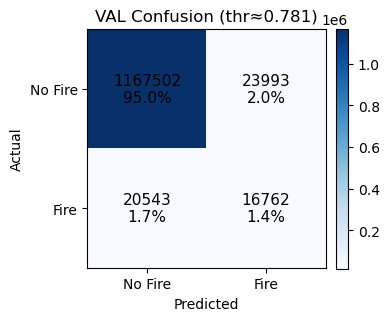

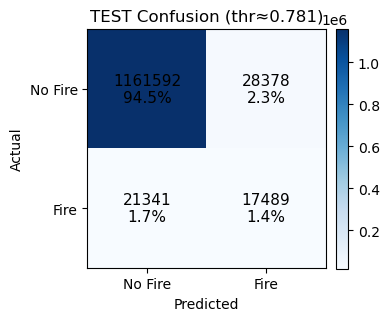

In [ ]:
import numpy as np

best_name, best_stats = max(final_metrics.items(), key=lambda kv: kv[1]["val_ap"])
best_model = variants[best_name]
best_thr = best_stats["val_thr"]
print(f"Using {best_name} weights for confusion/PR with thr≈{best_thr:.3f}")

@torch.no_grad()
def confusion_at_thr(model_obj, loader, thr):
    model_obj.eval()
    tp = fp = tn = fn = 0
    for batch in loader:
        feats, y = _forward_batch(model_obj, batch)
        logits = model_obj(feats)
        p = torch.sigmoid(logits).flatten().cpu().numpy()
        t = y.flatten().cpu().numpy().astype(np.uint8)
        p = np.nan_to_num(p, nan=0.0)
        yhat = (p >= thr).astype(np.uint8)
        tp += np.logical_and(yhat == 1, t == 1).sum()
        fp += np.logical_and(yhat == 1, t == 0).sum()
        tn += np.logical_and(yhat == 0, t == 0).sum()
        fn += np.logical_and(yhat == 0, t == 1).sum()
    tp, fp, tn, fn = map(int, (tp, fp, tn, fn))
    prec = tp / (tp + fp + 1e-8)
    rec  = tp / (tp + fn + 1e-8)
    f1   = 2 * prec * rec / (prec + rec + 1e-8)
    return dict(tp=tp, fp=fp, tn=tn, fn=fn,
                precision=float(prec), recall=float(rec), f1=float(f1))

def _conf_matrix_from_counts(stats):
    return np.array([[stats["tn"], stats["fp"]],
                     [stats["fn"], stats["tp"]]], dtype=np.int32)

def _plot_confusion(cm, title):
    total = cm.sum()
    fig, ax = plt.subplots(figsize=(4, 4))
    im = ax.imshow(cm, cmap="Blues")
    ax.set_title(title)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")
    ax.set_xticks([0, 1])
    ax.set_yticks([0, 1])
    ax.set_xticklabels(["No Fire", "Fire"])
    ax.set_yticklabels(["No Fire", "Fire"])
    for (i, j), val in np.ndenumerate(cm):
        pct = (val / total * 100.0) if total else 0.0
        ax.text(j, i, f"{val}\n{pct:.1f}%", ha="center", va="center", color="black", fontsize=11)
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    plt.tight_layout()

val_stats = confusion_at_thr(best_model, val_loader, best_thr)
test_stats = confusion_at_thr(best_model, test_loader, best_thr)

print("VAL @thr:", val_stats)
print("TEST @thr:", test_stats)

_plot_confusion(_conf_matrix_from_counts(val_stats), f"VAL Confusion ({best_name}, thr≈{best_thr:.3f})")
_plot_confusion(_conf_matrix_from_counts(test_stats), f"TEST Confusion ({best_name}, thr≈{best_thr:.3f})")


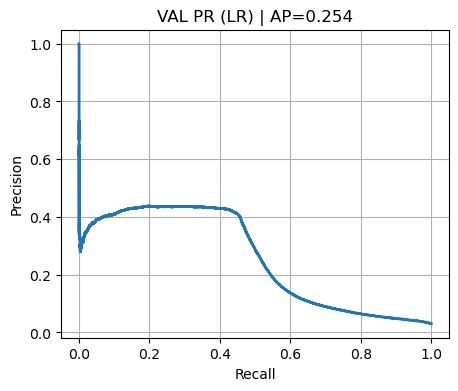

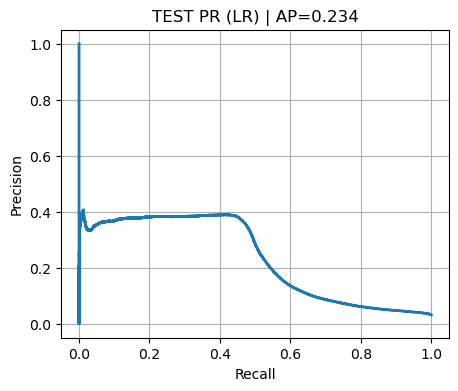

In [ ]:
@torch.no_grad()
def pr_curve(model_obj, loader, title="PR Curve"):
    model_obj.eval()
    ps, ts = [], []
    for batch in loader:
        feats, y = _forward_batch(model_obj, batch)
        p = torch.sigmoid(model_obj(feats)).flatten().cpu().numpy()
        t = y.flatten().cpu().numpy()
        ps.append(p)
        ts.append(t)
    p = np.concatenate(ps)
    t = np.concatenate(ts)
    prec, rec, _ = precision_recall_curve(t, p)
    ap = average_precision_score(t, p)
    plt.figure(figsize=(5, 4))
    plt.plot(rec, prec, lw=2)
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(f"{title} | AP={ap:.3f}")
    plt.grid(True)
    plt.show()

pr_curve(best_model, val_loader, f"VAL PR ({best_name})")
pr_curve(best_model, test_loader, f"TEST PR ({best_name})")


In [ ]:
# Utility to preview channel configurations for future ablations

def preview_channel_mix(include=None, exclude=None):
    preview = models.configure_channels(
        CHANNELS_FOR_MODEL,
        include=include,
        exclude=set(exclude or []),
    )
    print(f"Requested mix → {preview}")
    return preview

# Example (commented):
# preview_channel_mix(exclude={"ndvi", "rh"})


eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]

eval LR:   0%|          | 0/19 [00:00<?, ?it/s]


[LR] Single-feature VAL ablations (sorted by F1):
  prev_fire         AP=0.210  F1*=0.439
  erc               AP=0.046  F1*=0.094
  pdsi              AP=0.043  F1*=0.089
  bi                AP=0.043  F1*=0.088
  rh                AP=0.040  F1*=0.073
  temp              AP=0.037  F1*=0.068
  v                 AP=0.033  F1*=0.065
  slope             AP=0.035  F1*=0.065
  gust_med          AP=0.034  F1*=0.065
  pr                AP=0.032  F1*=0.063
  barrier           AP=0.032  F1*=0.062
  fuel3             AP=0.030  F1*=0.062
  fuel2             AP=0.032  F1*=0.061
  fuel1             AP=0.029  F1*=0.061
  ndvi              AP=0.028  F1*=0.061
  water             AP=0.031  F1*=0.060
  u                 AP=0.030  F1*=0.060
  impervious        AP=0.030  F1*=0.060
  wind_75           AP=0.027  F1*=0.060
  aspect            AP=0.030  F1*=0.060
  chili             AP=0.029  F1*=0.059
